In [ ]:
!pip install datasets>=2.6.1
!pip install git+https://github.com/huggingface/transformers
!pip install librosa
!pip install evaluate>=0.30
!pip install jiwer
!pip install gradio
!pip install -q bitsandbytes datasets accelerate loralib
!pip install transformers==4.45.2
!pip install peft
!pip install matplotlib
!pip install tensorboard

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-v05yj8iq
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-v05yj8iq
  Resolved https://github.com/huggingface/transformers to commit f2b59c6173191089dadda197554435ce96ae6c84
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
  Created wheel for transformers: filename=transformers-4.52.0.dev0-py3-none-any.whl size=11697451 sha256=e15e8c7cd1b3d9840a7b9fa5421b26f99936cb4878b37ea84a127a9d6355ef83
  Stored in directory: /tmp/pip-ephem-wheel-cache-cvl7mi9r/wheels/04/a3/f1/b88775f8e1665827525b19ac7590250f1038d947067beba9fb
Successfully built transformers
  Attempting 

In [ ]:
# -------------------Set model properties-----------------------------------
model_name_or_path = "openai/whisper-small"
language = "telugu"
task = "transcribe"

In [ ]:
#---------------------------Load Dataset--------------------------------------
from datasets import load_dataset, DatasetDict

# Load the full dataset
full_train = load_dataset("raghavab/telugu-asr-small", split="train")
full_test = load_dataset("raghavab/telugu-asr-small", split="test")



# Get dataset sizes
train_size = len(full_train)
test_size = len(full_test)

# Compute the original train-test ratio
original_ratio = test_size / train_size

# Compute the new test size corresponding to 60% train size
new_train_size = int(1 * train_size)
new_test_size = int(1 * test_size)

train_sample = full_train.shuffle(seed=42).select(range(new_train_size))
test_sample = full_test.shuffle(seed=42).select(range(new_test_size))

# Create a new dataset dictionary
bangla_dataset = DatasetDict({
    "train": train_sample,
    "test": test_sample
})


In [ ]:
#-----------Check dataset shape----------
bangla_dataset.shape

{'train': (3113, 2), 'test': (668, 2)}

In [ ]:
#-----------Check dataset structure----------
bangla_dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'transcript'],
        num_rows: 3113
    })
    test: Dataset({
        features: ['audio', 'transcript'],
        num_rows: 668
    })
})

In [ ]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name_or_path,language=language,task=task)

In [ ]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained(model_name_or_path,language=language,task=task)

In [ ]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(model_name_or_path, language=language, task=task)

In [ ]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

In [ ]:
#-------------------Check sampling rate before downsampling-----------------
print(bangla_dataset["train"][16])

{'audio': {'path': None, 'array': array([ 0.00039673,  0.00036621,  0.00030518, ..., -0.00012207,
       -0.00015259, -0.00021362]), 'sampling_rate': 48000}, 'transcript': 'వేర్లు దుంపలుగా నుండును'}


In [ ]:
#--------------------Downsample to 16 KHz--------------------------
from datasets import Audio

bangla_dataset = bangla_dataset.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
#-------------------Check sampling rate after downsampling-----------------
print(bangla_dataset["train"][0])

{'audio': {'path': None, 'array': array([-2.24399584e-04, -3.61349492e-04, -3.22890934e-04, ...,
       -7.33510751e-05,  1.43645535e-04,  0.00000000e+00]), 'sampling_rate': 16000}, 'transcript': 'అతన్ని తన సహాయకునిగా పెట్టుకున్నాడు'}


In [ ]:
# #------------------Custom preprocessing function for dataset-----------------------------
# def prepare_dataset(batch):
#     # load and resample audio data from 48 to 16kHz
#     audio = batch["audio"]

#     # compute log-Mel input features from input audio array
#     batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

#     # encode target text to label ids
#     batch["labels"] = tokenizer(batch["transcript"]).input_ids
#     return batch


In [ ]:
#------------------Custom preprocessing function with Spec Augment for dataset-----------------------------
import torch
import random

def apply_spec_augment(mel_spec, time_mask_param=20, freq_mask_param=10, num_time_masks=2, num_freq_masks=2):
    """Applies SpecAugment on a log-Mel spectrogram."""
    mel_spec = torch.tensor(mel_spec)  # shape: (80, time)

    # Frequency masking
    for _ in range(num_freq_masks):
        f = random.randint(0, freq_mask_param)
        f0 = random.randint(0, mel_spec.shape[0] - f)
        mel_spec[f0:f0+f, :] = 0

    # Time masking
    for _ in range(num_time_masks):
        t = random.randint(0, time_mask_param)
        t0 = random.randint(0, mel_spec.shape[1] - t)
        mel_spec[:, t0:t0+t] = 0

    return mel_spec.numpy()

def prepare_dataset(batch):
    audio = batch["audio"]
    input_features = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # Apply SpecAugment only during training
    if "train" in batch.get("__index_level__", "") or "train" in batch.get("split", ""):
        input_features = apply_spec_augment(input_features)

    batch["input_features"] = input_features
    batch["labels"] = tokenizer(batch["transcript"]).input_ids
    return batch


In [ ]:
#-------------------------Execute preprocessing---------------------------
bangla_dataset = bangla_dataset.map(prepare_dataset, remove_columns=bangla_dataset.column_names["train"], num_proc=1)


Map:   0%|          | 0/3113 [00:00<?, ? examples/s]

Map:   0%|          | 0/668 [00:00<?, ? examples/s]

In [ ]:
#--------------check dataset structure after preprocessing------------
bangla_dataset["test"]

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 668
})

In [ ]:
#--------------check dataset structure after preprocessing------------
bangla_dataset["train"]

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 3113
})

In [ ]:
#-------------------Check first sentence by decoding-----------------------
first_label_ids = bangla_dataset["train"][0]["labels"]  # Get the first label (token IDs)
first_sentence = tokenizer.decode(first_label_ids)  # Decode to text

print(first_sentence)


<|startoftranscript|><|te|><|transcribe|><|notimestamps|>అతన్ని తన సహాయకునిగా పెట్టుకున్నాడు<|endoftext|>


In [ ]:
# -----------------------------Visualization of sentence token sizes vs frequency------------------------
import matplotlib.pyplot as plt

list_of_transcription_lengths = []

# Extract labels from dataset and compute their lengths
for data in bangla_dataset["train"]:
    list_of_transcription_lengths.append(len(data["labels"]))

# Plot the histogram
plt.hist(list_of_transcription_lengths, bins=50)  # Adjust bins for better visualization
plt.xlabel("Sentence Length (Number of Tokens)")
plt.ylabel("Number of Transcripts")
plt.title("Distribution of Transcription Lengths")
plt.show()


In [ ]:
#------------------------------Check true vs prediction on few sentences before fine-tuning------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = model.generate(input_feature, language='telugu', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


-------7------
True : అనగా మన దేశానికి హిందీ అధికార భాష\n 
Pred :  अनगा मन देसानके हिंदी अदिखार भाशा

 
-------8------
True : ఈ సందర్భంలో ఒక కథ చెప్తాను 
Pred :  इस अंदर्बम लोग के कत चप्तानु

 
-------9------
True : జానకి రచన జి 
Pred :  जानकी रच्चना जी

 


In [ ]:
#-------------------------------------Define Data Collator to introduce padding-------------------------------
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [ ]:
#----------------------------Load Data Collator-----------------------------
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [ ]:
#------------------------Define evaluation metric wer------------------------
import evaluate
wer = evaluate.load("wer")

In [ ]:
#===================================Custom Evaluation Function for WER Metric with Periodic Plotting===================================
import torch
import pickle
from tqdm import tqdm
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

wer = evaluate.load("wer")
SAVE_PATH = "evaluation_progress.pkl"

def save_progress(progress):
    with open(SAVE_PATH, "wb") as f:
        pickle.dump(progress, f)

def load_progress():
    try:
        with open(SAVE_PATH, "rb") as f:
            return pickle.load(f)
    except FileNotFoundError:
        return {"predictions": [], "references": [], "processed_batches": 0, "wer_history": [], "batch_history": []}

def plot_wer(batch_history, wer_history):
    clear_output(wait=True)
    plt.figure(figsize=(10, 4))
    plt.plot(batch_history, wer_history, marker='o', label='WER (%)')
    plt.xlabel('Batches Processed')
    plt.ylabel('WER')
    plt.title('Running WER Evaluation')
    plt.grid(True)
    plt.legend()
    # Set ticks at intervals of 25 starting from 0 to max batch
    max_batch = max(batch_history) if batch_history else 0
    plt.xticks(np.arange(0, max_batch + 1, 25))
    display(plt.gcf())
    plt.close()

def evaluation(model, resume=False):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    test_dataset = bangla_dataset["test"]
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        collate_fn=data_collator
    )

    model.eval()

    # Load previous progress if resuming
    progress = load_progress() if resume else {"predictions": [], "references": [], "processed_batches": 0, "wer_history": [], "batch_history": []}
    predictions, references = progress["predictions"], progress["references"]
    start_batch = progress["processed_batches"]
    wer_history = progress.get("wer_history", [])
    batch_history = progress.get("batch_history", [])

    for batch_idx, batch in enumerate(tqdm(test_dataloader, total=len(test_dataloader))):
        if batch_idx < start_batch:
            continue  # Skip already processed batches

        input_features = batch["input_features"].to(device)
        labels = batch["labels"]

        with torch.no_grad():
            generated_tokens = model.generate(input_features=input_features, language='telugu', task='transcribe')

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels.tolist(), skip_special_tokens=True)

        predictions.extend(decoded_preds)
        references.extend(decoded_labels)

        is_final = (batch_idx == len(test_dataloader) - 1)
        if (batch_idx + 1) % 25 == 0 or is_final:
            current_wer = wer.compute(predictions=predictions, references=references) * 100
            wer_history.append(current_wer)
            batch_history.append(batch_idx + 1)
            plot_wer(batch_history, wer_history)
            save_progress({
                "predictions": predictions,
                "references": references,
                "processed_batches": batch_idx + 1,
                "wer_history": wer_history,
                "batch_history": batch_history
            })

    return wer_history[-1] if wer_history else None


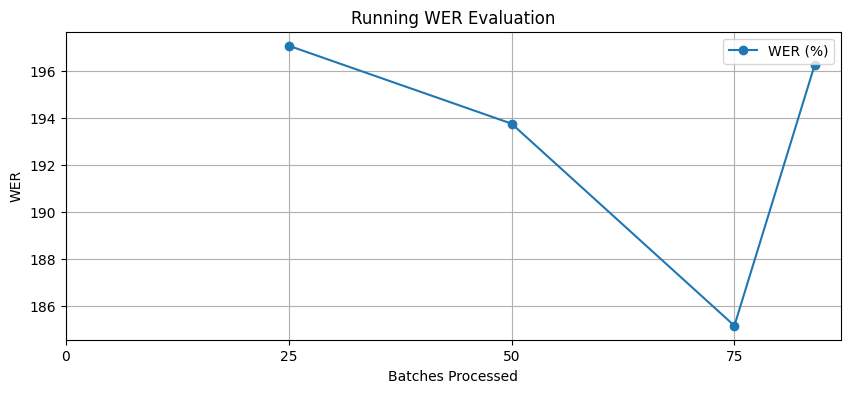

100%|██████████| 84/84 [17:13<00:00, 12.30s/it]


196.25445897740786

In [ ]:
# Evaluate WER before the training
torch.cuda.empty_cache()
# evaluation(model)
evaluation(model,resume=True)

In [ ]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

In [ ]:
#-----------------------------------Load and add LoRA model to base model-----------------------------------
from peft import LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model

config = LoraConfig(r=32, lora_alpha=64, target_modules=["k_proj", "v_proj", "q_proj", "out_proj"], lora_dropout=0.05, bias="none")

model = get_peft_model(model, config)
model.print_trainable_parameters()
for n,p in model.named_parameters():
    print(n,p.requires_grad)

trainable params: 7,077,888 || all params: 248,812,800 || trainable%: 2.8447
base_model.model.base_model.model.model.encoder.conv1.weight False
base_model.model.base_model.model.model.encoder.conv1.bias False
base_model.model.base_model.model.model.encoder.conv2.weight False
base_model.model.base_model.model.model.encoder.conv2.bias False
base_model.model.base_model.model.model.encoder.embed_positions.weight False
base_model.model.base_model.model.model.encoder.layers.0.self_attn.k_proj.base_layer.weight False
base_model.model.base_model.model.model.encoder.layers.0.self_attn.k_proj.lora_A.default.weight True
base_model.model.base_model.model.model.encoder.layers.0.self_attn.k_proj.lora_B.default.weight True
base_model.model.base_model.model.model.encoder.layers.0.self_attn.v_proj.base_layer.weight False
base_model.model.base_model.model.model.encoder.layers.0.self_attn.v_proj.base_layer.bias False
base_model.model.base_model.model.model.encoder.layers.0.self_attn.v_proj.lora_A.default

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [ ]:
#----------------------------Create Training Arguments------------------------------
from transformers import Seq2SeqTrainingArguments,EarlyStoppingCallback

training_args = Seq2SeqTrainingArguments(
    output_dir="lora-checkpoints",
    per_device_train_batch_size=2,  # Reduced from 8 to 2
    per_device_eval_batch_size=2,  # Reduced from 8 to 2
    gradient_accumulation_steps=2,  # Helps with small batch size
    # learning_rate=2e-5, (High)
    learning_rate=1e-5,  #(Medium)
    # learning_rate=5e-6,  #(Low)
    warmup_steps=50,
    num_train_epochs=2,
    # evaluation_strategy="epoch",
    evaluation_strategy="steps",
    eval_steps=250,
    # save_strategy="epoch",
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,  # Disabling to save memory
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,  # Mixed precision enabled
    generation_max_length=128,
    logging_steps=25,
    remove_unused_columns=False,
    label_names=["labels"],

    # Add AdamW optimizer and related arguments
    optim="adamw_torch",  # AdamW optimizer from PyTorch
    weight_decay=0.01,  # Regularization to prevent overfitting
    adam_epsilon=1e-8,   # Epsilon for numerical stability
    max_grad_norm=1.0,   # Gradient clipping
    # TensorBoard logging
    logging_dir="./lora-tensorboard",  # Directory for TensorBoard logs
    report_to="tensorboard",  # Enables logging to TensorBoard
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
#--------------------------------Create Trainer--------------------------------------
from transformers import Seq2SeqTrainer

# Use only 10% of the test dataset for evaluation
# eval_sample = bangla_dataset["test"].shuffle(seed=42).select(range(int(0.1 * len(bangla_dataset["test"]))))

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=bangla_dataset["train"],
    eval_dataset=bangla_dataset["test"],
    data_collator=data_collator,
    #compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
model.gradient_checkpointing_enable() #Gradient checkpointing helps save memory by recomputing activations during the backward pass.

In [ ]:
#-------------------Code for Cleaning GPU Cache--------------------------
# import torch
# import gc

# gc.collect()  # Clean up RAM
# torch.cuda.empty_cache()  # Free GPU memory

# print("✅ GPU memory forcibly cleared!")


✅ GPU memory forcibly cleared!


In [ ]:
#----------------Code to check stored huggingface dataset files in cache---------------
# !ls -lh ~/.cache/huggingface/datasets

total 4.0K
drwxr-xr-x 3 root root 4.0K Mar 17 21:31 imonghose___bengali-asr-data
-rw-r--r-- 1 root root    0 Mar 17 21:36 _root_.cache_huggingface_datasets_imonghose___bengali-asr-data_default_0.0.0_3a297ddede51b3012d3a6eb39e9dbea12b8ccc40.lock


In [ ]:
#--------------------Login to Huggingface (if required)-----------------------------------
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
#-------------------Check if a checkpoint file exists-----------------------
# ls -lh checkpoints/checkpoint-1197
# checkpoint_path = get_last_checkpoint("checkpoints")
# checkpoint_path

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#-------------------------------Start Training with support for checkpointing--------------------------
from transformers import AutoModelForSeq2SeqLM, AutoModelForCausalLM, Trainer
from transformers.trainer_utils import get_last_checkpoint
from transformers import WhisperForConditionalGeneration


checkpoint_path = get_last_checkpoint("lora-checkpoints")

if checkpoint_path is not None:
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    peft_base_model = get_peft_model(WhisperForConditionalGeneration.from_pretrained("openai/whisper-small"), config)
    loaded_model_from_checkpoint = PeftModel.from_pretrained(peft_base_model, checkpoint_path).to('cuda')
    model = loaded_model_from_checkpoint
    trainer.model = model  # Load the trained model into the trainer
    trainer.train(resume_from_checkpoint=checkpoint_path)  # Resume training
else:
    print("No checkpoint found, starting from scratch.")
    torch.cuda.empty_cache()
    trainer.train()  # Start training from scratch

No checkpoint found, starting from scratch.


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss
250,1.652000,1.611112
500,1.315900,1.294996
750,1.097200,1.078409
1000,0.958500,0.960909
1250,0.887800,0.896468
1500,0.837400,0.870869


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [ ]:
# --------------------------Save LoRa adaptors to "trained_model" directory---------------------------
trainer.save_model("lora_trained_model")

In [ ]:
import ast
import matplotlib.pyplot as plt

# === Paths to your log files ===
train_log_file = "LoRA_training_logs.txt"       # Training loss logs (step-level)
eval_log_file = "LoRA_evaluation_logs.txt"            # Eval loss logs (epoch-level)

# === Read and parse training log ===
train_data = []
with open(train_log_file, 'r') as f:
    for line in f:
        if line.strip():
            log_entry = ast.literal_eval(line.strip())
            train_data.append(log_entry)

# Extract training epochs and losses
train_epochs = [entry['epoch'] for entry in train_data]
train_losses = [entry['loss'] for entry in train_data]

# === Read and parse evaluation log ===
eval_data = []
with open(eval_log_file, 'r') as f:
    for line in f:
        if line.strip():
            log_entry = ast.literal_eval(line.strip())
            eval_data.append(log_entry)

# Extract evaluation epochs and losses
eval_epochs = [entry['epoch'] for entry in eval_data]
eval_losses = [entry['eval_loss'] for entry in eval_data]

# === Plot both training and evaluation loss curves ===
plt.figure(figsize=(10, 6))

# Training loss: blue with small circles
plt.plot(train_epochs, train_losses, linestyle='-', marker='o', markersize=4, label='Training Loss', color='blue')

# Evaluation loss: orange with square markers
plt.plot(eval_epochs, eval_losses, linestyle='-', marker='s', markersize=6, label='Evaluation Loss', color='orange')

# Labels, title, legend, etc.
plt.title("Training vs Evaluation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Evaluate WER after the training
torch.cuda.empty_cache()
evaluation(trainer.model, resume=True)

100%|██████████| 84/84 [01:11<00:00,  1.18it/s]


196.25445897740786

In [ ]:
#----------------------------Load LoRA adaptors from "trained_model" directory and add it to base model to reload---------------------------
from transformers import WhisperForConditionalGeneration
from peft import PeftModel
import torch

# Load base model
base_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

loaded_model = get_peft_model(base_model, config)

# Load LoRA adapter
loaded_model = PeftModel.from_pretrained(loaded_model, "lora_trained_model")

# ✅ Move model to GPU
loaded_model = loaded_model.to("cuda")



/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [ ]:
#-----------------------Alternative : Save full model to disk in "merged_full_model" directory---------------------------
# merged_full_model = trainer.model.merge_and_unload()  # merges LoRA into base model
# merged_full_model.save_pretrained("merged_full_model")  # now contains full model weights

#-------------------------------Reload the full model from local "merged_full_model" directory------------------------------------
# from transformers import WhisperForConditionalGeneration
# merged_full_model = WhisperForConditionalGeneration.from_pretrained("merged_full_model")
# # ✅ Move model to GPU
# merged_full_model = merged_full_model.to("cuda")



In [ ]:
#-------------------------------Save the loaded model to hugging face------------------------
from transformers import WhisperForConditionalGeneration

# Push to Hugging Face Hub
loaded_model.push_to_hub("raghavab/telugu-asr-small-lora-spec-test")



In [ ]:
#---------------------------------Reload the model from Hugging Face Hub-----------------------------------
# Load base model
base_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

peft_model = get_peft_model(base_model, config)
# loaded_model = get_peft_model(loaded_model, "trained_model")

# Load LoRA adapter
final_loaded_model = PeftModel.from_pretrained(peft_model, "raghavab/telugu-asr-small-lora-test")

# ✅ Move model to GPU
final_loaded_model = final_loaded_model.to("cuda")


adapter_config.json:   0%|          | 0.00/800 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/28.4M [00:00<?, ?B/s]

In [ ]:
#------------------------------Check true vs prediction on few sentences after fine-tuning (using trainer.model)------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = trainer.model.generate(input_feature, language='telugu', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


-------7------
True : అనగా మన దేశానికి హిందీ అధికార భాష\n 
Pred : అనగం మనదయసానికి మందిగారవాసా

 
-------8------
True : ఈ సందర్భంలో ఒక కథ చెప్తాను 
Pred : ఈ సందరమంలో కక చపటాంతు

 
-------9------
True : జానకి రచన జి 
Pred : జానక్రిచనా చేంగ్ల్ల్

 


In [ ]:
#------------------------------Check true vs prediction on few sentences after fine-tuning (using model loaded from local i.e "trained_model")------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = loaded_model.generate(input_feature, language='telugu', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


-------7------
True : అనగా మన దేశానికి హిందీ అధికార భాష\n 
Pred :  अनगा मन देसानके हिंदी अदिखार भाशा

 
-------8------
True : ఈ సందర్భంలో ఒక కథ చెప్తాను 
Pred :  इस अंदर्बम लोग के कत चप्तानु

 
-------9------
True : జానకి రచన జి 
Pred :  जानकी रच्चना जी

 


In [ ]:
#------------------------------Check true vs prediction on few sentences after fine-tuning (using model loaded from hugging face)------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = final_loaded_model.generate(input_feature, language='telugu', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


-------7------
True : అనగా మన దేశానికి హిందీ అధికార భాష\n 
Pred :  अनगा मन देसानके हिंदी अदिखार भाशा

 
-------8------
True : ఈ సందర్భంలో ఒక కథ చెప్తాను 
Pred :  इस अंदर्बम लोग के कत चप्तानु

 
-------9------
True : జానకి రచన జి 
Pred :  जानकी रच्चना जी

 
